In [31]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb

In [ ]:
user = 'agoutam'

In [32]:
def evalAllQueries(pairsFile, annotFile, pathsRoot, editDur, scoring_collar = 0.1, numThresholds = 1000, \
                   saveFile = None, hop_sec = 512 / 22050):
    insertionAttributions = []
    deletionAttributions = []
    replacementAttributions = []
    
    annotList = list(map(lambda x: x.split(), open(annotFile, 'r').readlines()))
    
    with open(pairsFile, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            
            # Find correct annotations
            queryId = os.path.basename(parts[0])[:-4] # [:-4] here to get rid of .wav
            annot = findAnnot(annotList, queryId)
            
            # Find path
            #pathBasename = queryId + '__' + os.path.basename(parts[1])  # This will need to change based on file structure
            pathFile = pathsRoot + '/' + queryId[:-4] + '.pkl' # [:-4] here to get rid of _160
            path = pkl.load(open(pathFile, 'rb'))

            tamperType, theseAttributions = evalQuery(path, annot, scoring_collar, editDur, hop_sec)
            
            # Add new costs and GT to
            if tamperType == "N":
                continue
            elif tamperType == "I":
                insertionAttributions += theseAttributions
            elif tamperType == "D":
                deletionAttributions += theseAttributions
            else:
                replacementAttributions += theseAttributions

    # Get ROCs
    insertionROC = calc_ROC(np.array(insertionAttributions), numThresholds)
    deletionROC = calc_ROC(np.array(deletionAttributions), numThresholds)
    replacementROC = calc_ROC(np.array(replacementAttributions), numThresholds)
    combined = np.array(insertionAttributions + deletionAttributions + replacementAttributions)
    combinedROC = calc_ROC(combined, numThresholds)
    
    if saveFile is not None:
        outdir = os.path.dirname(saveFile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        pkl.dump([insertionROC, deletionROC, replacementROC, combinedROC], open(saveFile, 'wb'))
    
    return [insertionROC, deletionROC, replacementROC, combinedROC]

In [33]:
def findAnnot(annotList, queryId):
    for annot in annotList:
        if annot[1] == queryId:
            return annot
    
    print("Error: Annotations not found")
    return None

In [34]:
def evalQuery(hyp, annot, scoring_collar, editDur, hop_sec):
    
    tamperType = annot[0]
    attributions = []
    path = hyp['wp']
    dists = hyp['dist']
    
    # set up boundaries list (in seconds, relative to modified query)
    # In form matchingRegionStart, tamperStart, tamperEnd, matchingRegionEndEnd
    # This will depend on tamperType
    if tamperType == "N":
        return tamperType, attributions
    
    elif tamperType == "I":
        insertionStart = float(annot[5])
        insertionEnd = insertionStart + editDur
        offset = 0
        
        # I use +/- inf here to signal that the matching region extends to the first and last frames, and no scoring
        # collar is needed
        boundaries = [-float('inf'), insertionStart, insertionEnd, float('inf')]
        query_length = path[0,0]
        startFrame = 0 # startFrame only used for deletions where the path is in the complete wrong place

    elif tamperType == "D": # For deletions, also flip query and reference
        queryPath = np.copy(path[:,0])
        refPath = np.copy(path[:,1])
        path[:,0] = refPath
        path[:,1] = queryPath
        
        deletionStart = float(annot[5])
        deletionEnd = deletionStart + editDur
        offset = float(annot[3])
        matchEnd = float(annot[4]) - offset # This should be 10
        query_length = path[0,0]
        startFrame = path[-1,0]
        
        # Here, the matching region starts and ends at the boundaries of the query recording
        boundaries = [offset, deletionStart + offset, deletionEnd + offset, matchEnd + offset]
        
    
    else: # replacement
        replacementStart = float(annot[5])
        replacementEnd = float(annot[6])
        offset = 0
        
        # Again, the matching region will extend all the way to the first and last frames
        boundaries = [-float('inf'), replacementStart, replacementEnd, float('inf')]
        query_length = path[0,0]
        startFrame = 0
    
    gt = getAttributionsGT(query_length, offset, boundaries, scoring_collar, hop_sec, startFrame)

    # Impute cost scores
    # Interpolate here to fill in the frames that the path jumps over
    costs = np.interp(np.arange(startFrame, query_length), path[:,0][::-1], dists[::-1])
    for i in range(gt.shape[0]):
        if gt[i] >=0:
            attributions.append([gt[i], costs[i]])
         
    return tamperType, attributions

In [35]:
def getAttributionsGT(query_length, offset, boundaries, scoring_collar, hop_sec, startFrame = 0):
    
    gt = np.zeros(query_length - startFrame)
        
    # Get the GT for each frame
    # For now, just represent each frame with a single timestamp (at where the frame begins)
    for frame in range(startFrame, query_length):
        t_query = frame * hop_sec
        if withinCollar(t_query, boundaries, scoring_collar):
            gt[frame-startFrame] = -1
        elif t_query < boundaries[0] or (t_query > boundaries[1] and t_query < boundaries[2]) or t_query > boundaries[3]:
            gt[frame-startFrame] = 1 # Non-matching region
        else:
            gt[frame-startFrame] = 0
            
    return gt

In [36]:
def withinCollar(t_query, boundaries, scoring_collar):
    for t_boundary in boundaries:
        if np.abs(t_query - t_boundary) < scoring_collar:
            return True
    return False

In [37]:
def calc_ROC(attributions, numThresholds):
    '''
    Calculates ROC curve for attributions based on number of thresholds
    
    '''
    
    costs = attributions[:,1]
    gt = attributions[:,0]
        
        
    # Get minimum and max for thresholds
    thresholdMin = np.min(costs)
    thresholdMax = np.max(costs)
    
    thresholds = np.linspace(thresholdMin, thresholdMax, numThresholds)
    ROC = np.ones((numThresholds,3))*-1
    
    # For each threshold, calculate false positive and false negative (miss) rate
    for i, threshold in enumerate(thresholds):
        FPCountTot = 0
        FNCountTot = 0
        TrueNegCount = 0
        TruePosCount = 0
        
        FPCount, FNCount = calcFPFN(costs, gt, threshold)

        TrueNegCount += np.sum(gt == 1) # Note: Positive means match
        TruePosCount += np.sum(gt == 0)

        FPCountTot += FPCount
        FNCountTot += FNCount
        
        # Threshold, False Positive, False Negative
        ROC[i,:] = [threshold, FPCountTot/TrueNegCount, FNCountTot/TruePosCount]
    
    return ROC

In [38]:
def calcFPFN(costVec, gtAttribution, threshold):
    '''
    Calculate number of false positives and false negatives
    '''
    
    # If cost is lower than threshold, then we consider sample in
    # non tampered region (nontampered = 0, tampered = 1)
    costHypVec = (costVec >= threshold).astype(int)

    diffVec = (costHypVec - gtAttribution)

    FPCount = np.sum((diffVec == -1).astype(int))
    FNCount = np.sum((diffVec == 1).astype(int))

    return FPCount, FNCount

In [63]:
editTimes = [2]
benchmark = 'train'
systems = ["D4"]
for editTime in editTimes:
    for sys in systems:
        pairsFile = "/mnt/data0/{}/TamperingDetection/cfg_files/{}_{}s.pairs".format(user, benchmark, editTime)
        annotFile = "/mnt/data0/{}/TamperingDetection/annots/160kbps_{}sec.gt".format(user, editTime)
        pathsRoot = "/mnt/data0/{}/TamperingDetection/hyp/{}sec/{}".format(user, editTime,sys)
        saveFile = "/mnt/data0/{}/TamperingDetection/eval/{}/{}_{}s.pkl".format(user, sys, benchmark, editTime)
        
        _ = evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

### Figures

In [64]:
def plotAttribution(timesToPlot, systemsToPlot, benchmark, sysNames):
    fig, axs = plt.subplots(1, len(timesToPlot), figsize = (10, 7))

    for i, plotTime in enumerate(timesToPlot):
        x = np.arange(len(systemsToPlot))
        numBars = 3
        width = 0.75 / numBars
        axs[i].grid(zorder=0)
        insertions = []
        deletions = []
        replacements = []
        for j, plotSys in enumerate(systemsToPlot):
            
            ROCfile = "/mnt/data0/{}/TamperingDetection/eval/{}/{}_{}s.pkl".format(user, plotSys, benchmark, editTime)

            
            ROCs = pkl.load(open(ROCfile, 'rb'))
            insertions.append(findEER(ROCs[0]))
            deletions.append(findEER(ROCs[1]))
            replacements.append(findEER(ROCs[2]))

        axs[i].bar(x - width, np.array(insertions) * 100, width, zorder = 3)
        axs[i].bar(x, np.array(deletions) * 100, width, zorder = 3)
        axs[i].bar(x + width, np.array(replacements) * 100, width, zorder = 3)
        
        
        axs[i].set_xlabel("System")
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(sysNames, rotation = 90)
        axs[i].set_ylim(0,35)
        axs[i].set_title("L = " + str(plotTime))

    plt.legend(["Insertions", "Deletions", "Replacements"], loc = (1.1, 0.5))
    fig.suptitle("Attribution Error Rates", fontsize = 'x-large')
    axs[0].set_ylabel("Equal Error Rate (%)", fontsize = "large")
    fig.tight_layout()

In [65]:
def findEER(ROC):
    '''
    Calculates Equal Error Rate based on ROC
    
    '''
    minDiff = np.inf
    savedFP = 0
    savedFN = 0

    for rate in ROC:
        FP = rate[1]
        FN = rate[2]

        if np.abs(FP - FN) < minDiff:
            minDiff = np.abs(FP - FN)
            savedFP = FP
            savedFN = FN
            
    return (savedFP + savedFN) / 2

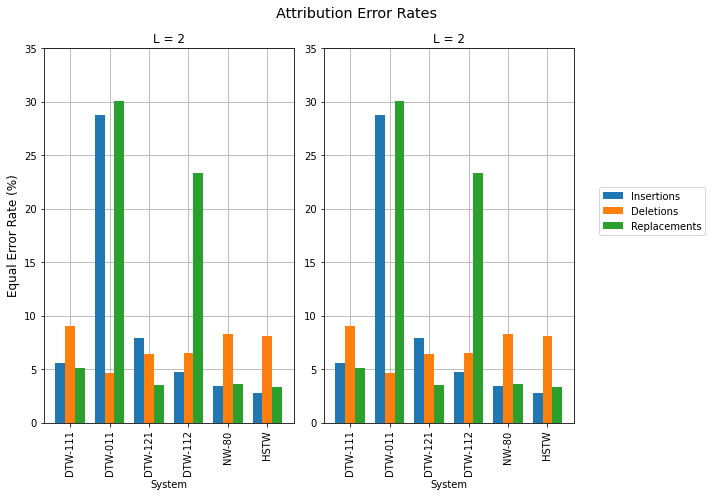

In [62]:
timesToPlot = [2,2]
systemsToPlot = ["D1", "D2", "D3", "D4", "NW-80", "HSTW"]
sysNames = ["DTW-111", "DTW-011","DTW-121", "DTW-112", "NW-80", "HSTW"]
benchmark = "train"

plotAttribution(timesToPlot, systemsToPlot, benchmark, sysNames)

In [67]:
ROCfile = "/mnt/data0/{}/TamperingDetection/eval/D3/train_2s.pkl".format(user)
ROCs = pkl.load(open(ROCfile, 'rb'))

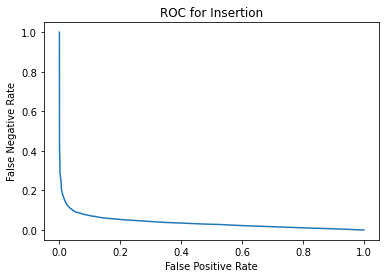

In [68]:
ROC = ROCs[0]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Insertion");

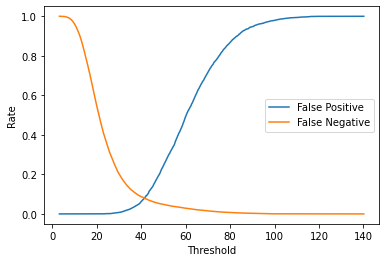

In [69]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

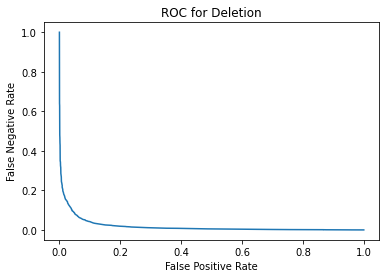

In [70]:
ROC = ROCs[1]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Deletion");

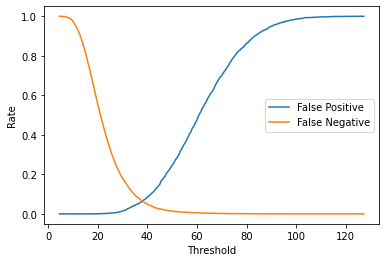

In [71]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

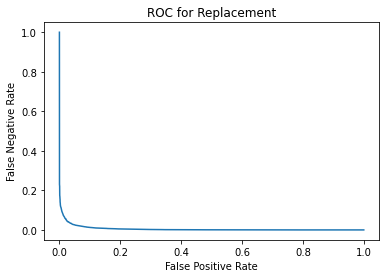

In [72]:
ROC = ROCs[2]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Replacement");

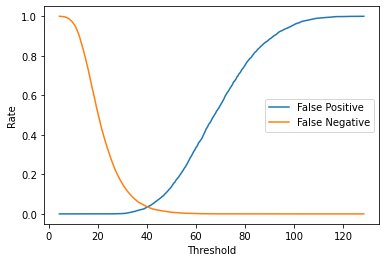

In [73]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

## Finding NW Gamma

In [74]:
editTime = 2

In [7]:
expGammas = [0.1, 1, 10, 100, 1000]
# for gamma in expGammas:
#     pairsFile = "/mnt/data0/agoutam/TamperingDetection/cfg_files/train_2s.pairs"
#     annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_2sec.gt"
#     pathsRoot = "/mnt/data0/tshaw/TamperingDetection/hyp/NW/train_2s/gamma=%s" % str(gamma)
#     saveFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
        
#     _ = evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

In [8]:
EERs = []
for gamma in [0.1, 1, 10, 100, 1000]:
    ROCFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
    ROC = pkl.load(open(ROCFile, "rb"))[3]
    EERs.append(findEER(ROC))

In [9]:
EERs

[0.4786605427714567,
 0.4834524619095293,
 0.4818794445850787,
 0.051320447379096495,
 0.11395771966801556]

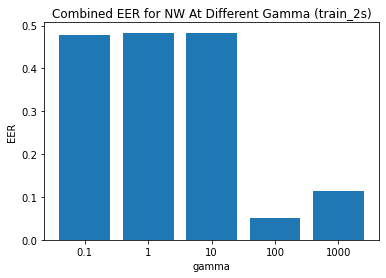

In [10]:
plt.bar(np.arange(5),EERs);
plt.xticks(np.arange(5), expGammas);
plt.xlabel("gamma")
plt.title("Combined EER for NW At Different Gamma (train_2s)");
# plt.ylim(0,1);
plt.ylabel("EER");

In [15]:
expGammas2 = [50, 100, 200, 500]
# for gamma in expGammas2:
#     pairsFile = "/mnt/data0/agoutam/TamperingDetection/cfg_files/train_2s.pairs"
#     annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_2sec.gt"
#     pathsRoot = "/mnt/data0/tshaw/TamperingDetection/hyp/NW/train_2s/gamma=%s" % str(gamma)
#     saveFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
        
#     _ = evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

In [16]:
EERs = []
for gamma in expGammas2:
    ROCFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
    ROC = pkl.load(open(ROCFile, "rb"))[3]
    EERs.append(findEER(ROC))

In [17]:
EERs

[0.054543195954302265,
 0.051320447379096495,
 0.11081710593351798,
 0.1139270633076631]

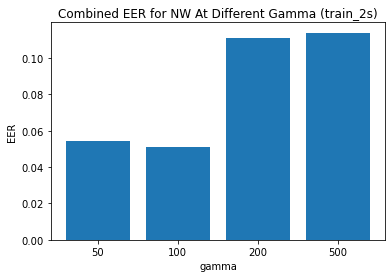

In [20]:
plt.bar(np.arange(len(EERs)),EERs);
plt.xticks(np.arange(len(EERs)), expGammas2);
plt.xlabel("gamma")
plt.title("Combined EER for NW At Different Gamma (train_2s)");
# plt.ylim(0,1);
plt.ylabel("EER");

In [42]:
linGammas = [50, 60, 70, 80, 90, 100]
# for gamma in linGammas:
#     pairsFile = "/mnt/data0/agoutam/TamperingDetection/cfg_files/train_2s.pairs"
#     annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_2sec.gt"
#     pathsRoot = "/mnt/data0/tshaw/TamperingDetection/hyp/NW/train_2s/gamma=%s" % str(gamma)
#     saveFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
        
#     _ = evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

In [43]:
EERs = []
for gamma in linGammas:
    ROCFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
    ROC = pkl.load(open(ROCFile, "rb"))[3]
    EERs.append(findEER(ROC))

In [44]:
EERs

[0.054543195954302265,
 0.05206043397068241,
 0.049069678056523,
 0.04846582882389572,
 0.04946689419920694,
 0.051320447379096495]

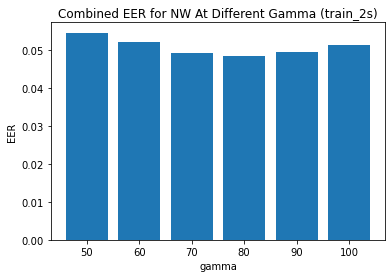

In [45]:
plt.bar(np.arange(len(EERs)),EERs);
plt.xticks(np.arange(len(EERs)), linGammas);
plt.xlabel("gamma")
plt.title("Combined EER for NW At Different Gamma (train_2s)");
# plt.ylim(0,1);
plt.ylabel("EER");